## Ptychography reconstruction by WDD method and aberration measurement: user guide.

This notebook explains how to use the Wigner-distribution deconvolution (WDD) software and aberration measurement program. It was  originally developed by Katsuaki Nakazawa(ICYS fellow at NIMS, Japan) and debugged and modified by Kazutaka Mitsuishi (NIMS, Japan) based on the following papers and books: 

Pennycook, T. J. et al. Efficient phase contrast imaging in STEM using a pixelated detector. Part 1: experimental demonstration at atomic resolution. Ultramicroscopy 151, 160-167, doi:10.1016/j.ultramic.2014.09.013 (2015).
Yang, H. et al. Simultaneous atomic-resolution electron ptychography and Z-contrast imaging of light and heavy elements in complex nanostructures. Nat Commun 7, 12532, doi:10.1038/ncomms12532 (2016).
Rodenburg, J. & Maiden, A. in Springer handbook of microscopy   (eds P. W. Hawkes & John C. H. Spence) Ch. 17, (Springer Nature, 2019).
Rodenburg, J. M.   Advances in Imaging and Electron Physics   87-184 (2008).

*Disclaimer*
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

 ## Generating 4DSTEM simulation data
 
Since the data size can be huge, and we cannot disclose any manufacturer related information, we first create a test 4DSTEM dataset from a tif image. Assuming that the tif image is a pure phase object, we obtain diffraction pattern at each probe position by multiplying the image with the probe function and propagating it to the diffraction plane.
This code also shows how the data should be stored for processing them with the WDD reconstruction code, where in order to avoid memory issues, diffraction patterns are grouped for each scan line and saved in separate files.
Note that in a proper 4DSTEM simulation, the real-space super cell size defines the unit of reciprocal space. These parameters should be consistent with the CCD pixel size and scattering angles.



## !!! important !!!  Please make sure to install all libraries used in the code.
Please check the import section both in this notebook and in the individual python files.


The code is tested under the following environment.
python                    3.8.13
hyperspy                  1.6.5
cupy                      10.3.1
opencv                    4.5.5

*The following class can create 4DSTEM data from a tif file as a phase object.

In [1]:
# please specfy the holder you locate the code.
%cd G:\4DCanvasData\PtychographyCode\PtychogarphyCodeForOpen
    
import glob
import math
import os
import shutil
import numpy as np
import configparser
from PIL import Image
import hyperspy.api as hs
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
import os

import stem4d as stem4d


fld = "G:\\4DCanvasData\\PtychographyCode"# Specify the code folder
print(fld)

class testDataMaker():
    def __init__(self, foldername):
        if foldername[-1] != '/': 
            foldername += '/'
        self.foldername = foldername

    def Make_M(self,foldername):
        # # Create a probe function with the same with as the scan width, and Fourier transform it in k-space
        # Map it to the detector pixels
        
        print("self.x=",self.x)
        print("self.y=",self.y)
        print("self.kx=",self.kx)
        print("self.ky=",self.ky)
        print("self.wavelength",self.wavelength)
        print("self.pixelsize=",self.pixelsize)
        print("self.pixelsize_k=",self.pixelsize_k)
        print("self.pixelsize * self.x=",self.pixelsize * self.x)
        print("self.pixelsize_k* self.kx=",self.pixelsize_k * self.kx)
        print("self.visualfield",self.visualfield)
        print("self.pixelsize*self.pixelsize_k/self.wavelength=",self.pixelsize*self.pixelsize_k/self.wavelength)
        
        print("aberraion_array=",self.aberraion_array)
        
        self.radius = 20 # mrad
        print("aperture radius= ",self.radius)
        print("resolution limited by aperture=", self.wavelength * 1000 / self.radius)

        source_phase_file_name = self.foldername + "\\Si110_7x5_128.tif"
        source_phase= cv2.imread(source_phase_file_name)
        source_phase = cv2.resize(source_phase,(128,128))
        source_phase = cv2.cvtColor(source_phase, cv2.COLOR_BGR2GRAY)
        plt.imshow(source_phase)
        plt.show()

        object_function = np.zeros((self.y, self.x)).astype(np.complex)
        
        
        
        #accvol  (volts)
        accvol = 200000
        # wavelength  (Angstroms)
        wavelength_Angstrom  = 12.264/(math.sqrt(accvol*(1+9.7846*1e-7*accvol)))
        object_function = np.exp(1j * wavelength_Angstrom * source_phase)
       
        plt.imshow(np.angle(object_function))
        plt.show()
        
        os.makedirs(self.foldername+'Lines', exist_ok=True)
        images = np.zeros((self.ky, self.kx, self.x),dtype=np.uint16)
        
        probe_k = np.zeros((self.ky, self.kx)).astype(np.complex)
        phase_probe = np.zeros((self.y, self.x)).astype(np.complex)
        probe_realspace = np.zeros((self.y, self.x)).astype(np.complex)
        
        aperture0 = self.make_circularfilter_for_sim(self.radius) * self.make_aberraioneration_image_for_sim(self.aberraion_array)
        
        print("Probe at aperture plane(abs)")
        plt.imshow(np.abs(aperture0))
        plt.show() 
        print("Probe at aperture plane(phase)")
        plt.imshow(np.angle(aperture0))
        plt.show()     
       
        Q_x =int( self.kx//2 * 0.001 / self.wavelength  * self.visualfield)
        Q_y =int( self.ky//2 * 0.001 / self.wavelength  * self.visualfield)

        print("Q_x=",Q_x)
        print("Q_y=",Q_y)
        
        
        for yp in range(self.y):
            for xp in range(self.x):
                
                for ky in range(self.y):
                    for kx in range(self.x):
                        phase_probe[ky,kx] = np.exp(-2.0 * np.pi * 1j
                                                    * ( yp/self.y  * (ky-self.y//2) + xp/self.x  * (kx-self.x//2))
                                                    )
                phase_probe *= aperture0
                probe_realspace = np.fft.ifft2(np.fft.ifftshift(phase_probe))
                probe_k = np.fft.fftshift(np.fft.fft2(probe_realspace * object_function  ))
                
                trimed_probe_k_r = Image.fromarray(np.real(probe_k)).crop((self.x//2-Q_x,self.y//2-Q_y,self.x//2+Q_x,self.y//2+Q_y))
                trimed_probe_k_i = Image.fromarray(np.imag(probe_k)).crop((self.x//2-Q_x,self.y//2-Q_y,self.x//2+Q_x,self.y//2+Q_y))
                
                probe_k_r =    np.array(trimed_probe_k_r.resize((self.ky,self.kx),Image.BILINEAR))
                probe_k_i =   np.array(trimed_probe_k_i.resize((self.ky,self.kx),Image.BILINEAR ))
                                        
                images[:,:,xp]=( probe_k_r**2 + probe_k_i**2)*256
                
                
                
            imagedata = hs.signals.Signal2D(images.transpose(2,0,1).astype(np.int16))
            np.save(self.foldername+'/Lines/line_'+str(yp),imagedata)
              
    def make_circularfilter_for_sim(self,o_angle_mrad):
        
        d_filter = np.zeros((self.y, self.x))
        x_array = np.arange((self.x))- self.x//2 
        y_array = (self.y//2-np.arange((self.y))).reshape(-1,1)
        d_array = np.sqrt(np.square(x_array)+ np.square(y_array)) * self.wavelength /  self.visualfield # [rad]
        
        o_angle_pixel = o_angle_mrad * 0.001 # [rad]
        d_filter[np.where(d_array<= o_angle_pixel)] = 1 
        return d_filter

  

    def make_aberraioneration_image_for_sim(self, aberraion_array):#
        aberraion_phase = np.zeros((self.y, self.x))
        for ky in range(self.y):
            for kx in range(self.x):
                ky_rad = (ky-self.y//2) * self.wavelength / self.visualfield
                kx_rad = (kx-self.x//2) * self.wavelength / self.visualfield
                
                aberraion_phase[ky, kx] = self.calc_aberraionerations(ky_rad,kx_rad).dot(aberraion_array)
                
        aberraion = np.exp(1j * aberraion_phase)
        return aberraion

    def calc_aberraionerations(self, y, x):
        aberraioneration = np.array([(x**2 + y**2)/2,
                               (x**2 - y**2)/2,
                               x*y,
                               (x**3 - 3*x*y**2)/3,
                               (3*x**2*y - y**3)/3,
                               (x**3 + x*y**2)/3,
                               (y**3 + x**2*y)/3,
                               (x**4 + y**4 + 2*x**2*y**2)/4,
                               (x**4 + y**4 - 6*x**2*y**2)/4,
                               x**3*y - x*y**3,
                               (x**4 - y**4)/4,
                               (x**3*y + x*y**3)/2])
        aberraioneration *= 2*math.pi/(self.wavelength * 1e+9)
        return aberraioneration



G:\4DCanvasData\PtychographyCode\PtychogarphyCodeForOpen


C:\Users\Administrator\anaconda3\envs\abtem\lib\site-packages\cupy\_environment.py:436: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda110

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


G:\4DCanvasData\PtychographyCode


* run to make 4DSTEM data (it takes long time, and the time depends on hardware))

self.x= 128
self.y= 128
self.kx= 64
self.ky= 64
self.wavelength 2.507884216794908e-12
self.pixelsize= 2.1231731286410817e-11
self.pixelsize_k= 1.0
self.pixelsize * self.x= 2.7176616046605845e-09
self.pixelsize_k* self.kx= 64.0
self.visualfield 2.7176616046605845e-09
self.pixelsize*self.pixelsize_k/self.wavelength= 8.465993423550113
aberraion_array= [-3.02e+00  2.30e+00  6.61e+00 -1.37e+01 -7.04e+01  1.82e+02 -1.28e+02
 -4.94e+03  2.28e+03  6.20e+01  2.87e+03 -1.25e+03]
aperture radius=  20
resolution limited by aperture= 1.253942108397454e-10


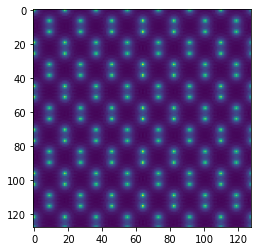

C:\Users\Administrator\AppData\Local\Temp\ipykernel_36948\916509296.py:58: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  object_function = np.zeros((self.y, self.x)).astype(np.complex)


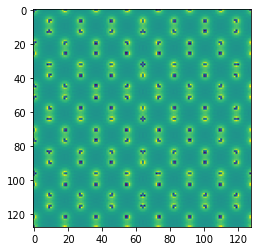

C:\Users\Administrator\AppData\Local\Temp\ipykernel_36948\916509296.py:74: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  probe_k = np.zeros((self.ky, self.kx)).astype(np.complex)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_36948\916509296.py:75: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  phase_probe = np.zeros

Probe at aperture plane(abs)


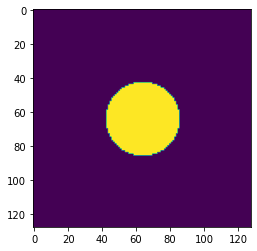

Probe at aperture plane(phase)


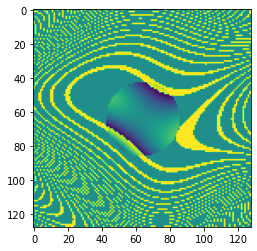

Q_x= 34
Q_y= 34


C:\Users\Administrator\AppData\Local\Temp\ipykernel_36948\916509296.py:109: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  probe_k_r =    np.array(trimed_probe_k_r.resize((self.ky,self.kx),Image.BILINEAR))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_36948\916509296.py:110: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  probe_k_i =   np.array(trimed_probe_k_i.resize((self.ky,self.kx),Image.BILINEAR ))


In [2]:
tdm=testDataMaker(fld)

tdm.x = 128 # number of real space scan points in x direction
tdm.y = 128 # number of real space scan points in y direction
tdm.kx = 64 # number of pixels of diffraction in x
tdm.ky = 64 # number of pixels of diffraction in y
tdm.wavelength =2.507884216794908e-12 # wave length
tdm.pixelsize= 2.1231731286410817e-11 # realspace pixel size
tdm.pixelsize_k= 1.0 # k-space pixel size
tdm.visualfield = 2.7176616046605845e-09 # field of view
tdm.radius=  20 # convergence semi-angel in mrad.
        
'''
Aberration Coefficients 
aberraion_array[0]: Defocus C1 :(nm)
aberraion_array[1]:Two-fold astigmatism C12a: (nm)
aberraion_array[2]:Two-fold astigmatism C12b: (nm) 
aberraion_array[3]:Three-fold astigmatism C23a: (nm)
aberraion_array[4]:Three-fold astigmatism C23b: (nm)
aberraion_array[5]:Axial coma C21a: (nm)
aberraion_array[6]:Axial coma C21b: (nm)
aberraion_array[7]:Spherical aberration C3: (μm)
aberraion_array[8]:Four-fold astigmatism C34a: (μm)
aberraion_array[9]:Four-fold astigmatism C34b: (μm)
aberraion_array[10]:Star aberration C32a: (μm)
aberraion_array[11]:Star aberration C32b: (μm)
'''
#Aberration Coefficients 
tdm.aberraion_array = np.zeros((12)) # [nm]
tdm.aberraion_array[0]=-3.02 #  [nm]
tdm.aberraion_array[1]=2.3 #  [nm]
tdm.aberraion_array[2]=6.61 #  [nm]
tdm.aberraion_array[3]=-13.7 #  [nm]
tdm.aberraion_array[4]=-70.4# [nm]
tdm.aberraion_array[5]=182 #  [nm]
tdm.aberraion_array[6]=-128 #  [nm]
tdm.aberraion_array[7]=-4940 #  [nm]
tdm.aberraion_array[8]=2280 #  [nm]
tdm.aberraion_array[9]=+62.0 #  [nm]
tdm.aberraion_array[10]=2870 #  [nm]
tdm.aberraion_array[11]=-1250 #  [nm]

tdm.Make_M(fld)

## Ptychography calculation
First, perform 2D-Fourier transformation for each 2D scan pixel (4D dataset)

*******FFT 4D starts*****************: 15:13:42.007019
*******Reading line data*****************: 15:13:42.011014
*******FFT starts*****************: 15:13:43.701261
*******FFT finished. Start saving*****************: 15:13:48.153309
******* input data ready start Pool *****************: 15:13:48.154308
finish saving fft_ line by line  data: 15:14:57.475843
Start making fft_abs image with Pool: 15:14:57.475843


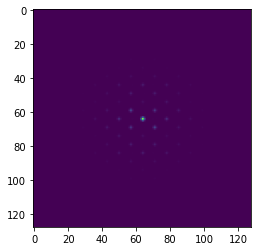

finish making fft_abs image with Pool: 15:15:12.138305


In [3]:
import importlib
import Ptychography as Ptychography
importlib.reload(Ptychography)
pty = Ptychography.Ptychograph(fld)

# again, acquistion parameters are set manually...
pty.x = 128
pty.y = 128
pty.kx = 64
pty.ky = 64
pty.wavelength =2.507884216794908e-12
pty.pixelsize= 2.1231731286410817e-11
pty.pixelsize_k= 1.0
pty.visualfield = 2.7176616046605845e-09
pty.radius=  20
pty.bin = 1
pty.accvol = 200
pty.cen_ky=32
pty.cen_kx=32
pty.radius = 20
pty.cl = 168.75
pty.clap1 =100 
pty.mag = 71579

pty.FFT4D_CPU_Pool()


Since the Fourier transformation of scan and detector pixels are treated the same way in ptychography, you need to specify the relation between these two pixel types. The routine below defines the distance ratio of those, and the angle relation. In a real experiment, you have to do that for each pair of magnification and camera length.

Acc= 200  CL= 168.75  CLA= 100  mag= 71579  x= 128  bin= 1
distance_ratio= 0.9351203131148418  rotation[rad]= -0.016041404646643498
rotaion[deg]= -0.9191047837142201
G image at=(y,x):( 64 64 )


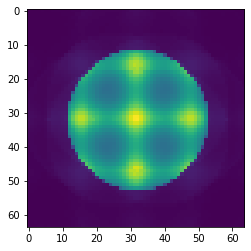

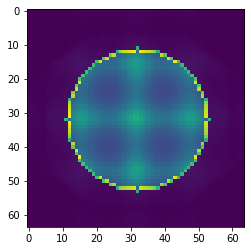

G image at=(y,x):( 59 57 )


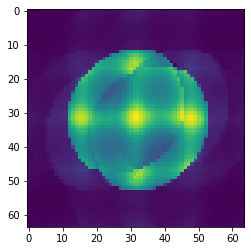

y,x, offset y,x= 59 57 -4.7799999999999985 -6.469999999999998


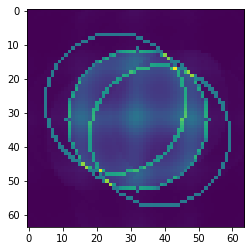

G image at=(y,x):( 59 71 )


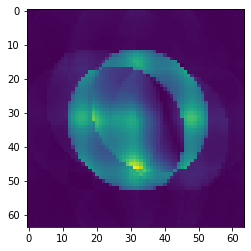

y,x, offset y,x= 59 71 -4.570000000000001 6.6199999999999966


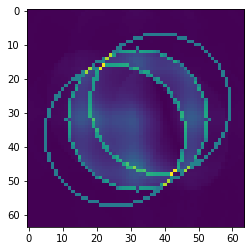

G image at=(y,x):( 64 50 )


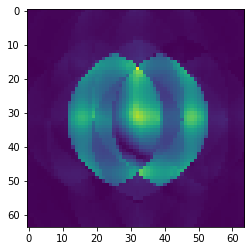

y,x, offset y,x= 64 50 -0.21000000000000077 -13.089999999999998


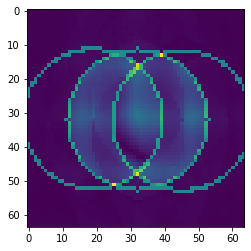

G image at=(y,x):( 44 64 )


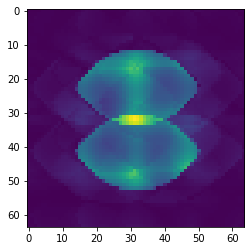

y,x, offset y,x= 44 64 -18.7 0.2999999999999958


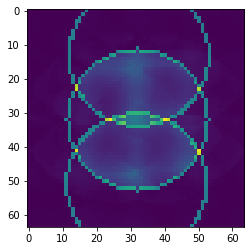

G image at=(y,x):( 49 57 )


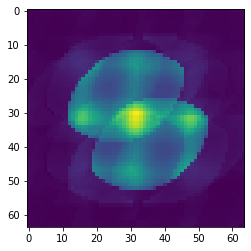

y,x, offset y,x= 49 57 -14.129999999999994 -6.3200000000000065


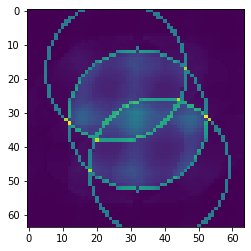

(0.9351203131148418, -0.016041404646643498)

In [4]:
pty.calc_distanceratio_and_rotation(13.3,32.3,44,64)

# Reconstruction by WDD
Because we add aberration to the probe, the obtained phase is distorted.

*******WDD starts*****************: 15:15:14.802526
*******Pool calculation finished. FFT by GPU starts*****************: 15:15:29.875543


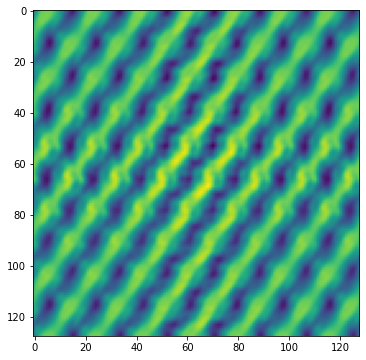

In [5]:
pty.WDD_multi()

# Aberration measurement.
You can specify the Q vector.  We use only those Qp values that have the best signal-to-noise ratio. (Yang, H. et al. Simultaneous atomic-resolution electron ptychography and Z-contrast imaging of light and heavy elements in complex nanostructures. Nat Commun 7, 12532, doi:10.1038/ncomms12532 (2016).)


In [6]:
aberrations = pty.measure_aberration_by_specific_Q_iterative(4, ((59, 71),(69, 57),(69, 71),(59, 57)))

aberr_mat.shape= (1220, 16)


plot of measured aberration figure

[ 2.74662203e+00 -2.17745198e+00 -6.59284175e+00  1.91162191e+01
  6.80666991e+01 -1.76549966e+02  1.31818706e+02  5.36632255e+03
 -1.97187907e+03  3.88658555e+02 -3.39089917e+03 -4.46394163e+02]
aberr image


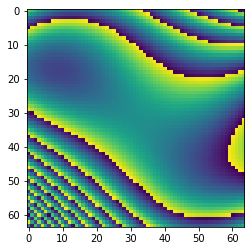

In [7]:
print(aberrations)
pty.show_aberration_figure(aberrations)

# Reconstruction by WDD with correction for the obtained aberration coefficients.


*******WDD starts*****************: 15:16:15.863909
*******Pool calculation finished. FFT by GPU starts*****************: 15:16:30.947044


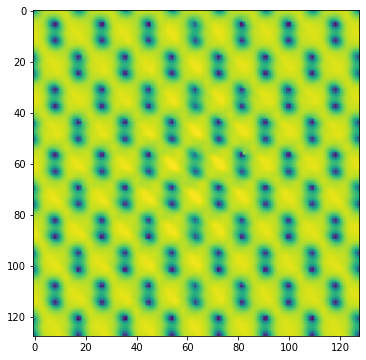

In [8]:
pty.WDD_multi(aberrations)